# Import

In [2]:
#path_essentials = '/Users/Setup3-PC/Desktop/qudi/logic/setup3_logic/script_logic_essentials.py'
path_essentials = 'jupyter/Timo/from_Simon/script_logic_essentials.py'
path_toolkit = 'jupyter/Timo/own/logic_toolkit.py'
path_curdir = 'jupyter/Timo/own/'

import os, time, sys
import numpy as np

# import essentials via run
exec(open(path_essentials).read())
exec(open(path_toolkit).read())
# usual module imports
sys.path.append(path_curdir)

import logging
logging.basicConfig(filename='logfile.log', filemode='w', level=logging.DEBUG)
logger = logging.getLogger(__name__)

# configure this notebook
config_matplotlib_jupyter()

memory_dict=OrderedDict()
print_welcome_msg()

[Wed Jun 19 17:00:40 2019] Hi, jupyter ready. working dir: C:\Users\Setup3-PC\Desktop\qudi


# Common parameters

In [3]:
# MW parameters
common_rabi_period = 78e-9
common_mw_freq = 1.5176e9 
common_mw_amp = 0.25/2.

# Ramsey
common_mw_ramsey_offset = 1e6#1e6

common_refocus_time = 300

# Laser options

## Optimize position

In [ ]:
optimize_position()

## Laser On

In [5]:
laser_on(pulser_on = False)
laser_on_awg()

## Laser Off

In [135]:
laser_off(pulser_on = False)

# Frequency Optimization parameters

In [ ]:
optimize_freq_dict=OrderedDict()
optimize_freq_dict['mw_optimization_method'] = 'pulsedodmr'
optimize_freq_dict['optimize_generate_new'] = False
optimize_freq_dict['save_tag'] = 'optimize_frequency'
optimize_freq_dict['optimize_fit_method'] = 'N15'
optimize_freq_dict['parameters2update'] = {'center': 'microwave_frequency'}

optimize_freq_dict['name'] = 'Pulsed_ODMR'
optimize_freq_dict['rabi_period'] = 1800e-9
optimize_freq_dict['freq_start'] = 4.127e9
optimize_freq_dict['freq_step'] = 0.2e6
optimize_freq_dict['num_of_points'] = 50
optimize_freq_dict['microwave_amplitude'] = common_mw_amp/15
optimize_freq_dict['meas_type'] = conventional_measurement
optimize_freq_dict['meas_info'] = add_conventional_information

optimize_freq_dict['measurement_time'] = 30
optimize_freq_dict['optimize_time'] = None
optimize_freq_dict['optimize_generate_new'] = True

#  Preperation 

In [4]:
def setup_podmr_params(f_start):
    qmeas=OrderedDict()
    qmeas['name'] = 'Pulsed_ODMR'
    qmeas['rabi_period'] = common_rabi_period*10
    qmeas['freq_start'] = f_start
    qmeas['freq_step'] = 0.1e6
    qmeas['num_of_points'] = 50
    qmeas['microwave_amplitude'] = common_mw_amp/20

    qmeas['measurement_time'] = 1500 
    qmeas['optimize_time'] = None
    qmeas['fit_experiment'] = 'lor_dip'
    
    return qmeas


def setup_rabi_params():
    
    qmeas=OrderedDict()
    qmeas['name'] = 'Rabi'
    qmeas['tau_start'] = 0e-9
    qmeas['tau_step'] = 2e-9
    qmeas['num_of_points'] = 50
    qmeas['microwave_frequency'] = common_mw_freq #+ 0.5*3.03e6
    qmeas['microwave_amplitude'] = common_mw_amp

    qmeas['measurement_time'] = None
    qmeas['optimize_time'] = None
    qmeas['freq_optimize_time'] = None
    #qmeas['fit_experiment'] = None  #'cosine'
    #qmeas['analysis_interval'] = 3
    #qmeas['n_sweeps'] = 5
    
    return qmeas

def setup_ramsey_pj_params(tau_start=50e-9, tau_step=50e-9, n_tau=10, tau_fist=50e-9, n_sweeps=1e3):
    qmeas=OrderedDict()
    qmeas['name'] = 'mfl_ramsey_pjump'
    qmeas['sequence_mode'] = True
    qmeas['rabi_period'] = common_rabi_period
    qmeas['microwave_frequency'] = common_mw_freq + common_mw_ramsey_offset
    qmeas['microwave_amplitude'] = common_mw_amp
    qmeas['tau_start'] = tau_start
    qmeas['tau_step'] = tau_step
    qmeas['n_sweeps'] = None     # for qudi control logic (slow)
    qmeas['n_seq_sweeps'] = n_sweeps   # awg sequence step repetitions (fast)
    qmeas['tau_first'] = tau_fist
    qmeas['num_of_points'] = n_tau
    qmeas['alternating'] = False
    
    qmeas['from_list'] = False
    
    qmeas['optimize_time'] = None
    qmeas['timer_interval'] = 100 # s, basically disable
    #qmeas['freq_optimization_time'] = None
    #qmeas['analysis_interval'] = 3
    
    # fast counter settings
    # todo: not working as expected atm
    #qmeas['ctr_single_sweeps'] = True
    #qmeas['ctr_n_sweeps'] = 96e3

    return qmeas


def run_pdomr(mes_params):
    
    up_to = (mes_params['freq_start'] + mes_params['freq_step'] * mes_params['num_of_points'])
    
    do_experiment(experiment='pulsedodmr', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information, 
                  generate_new=True, save_tag='PulsedOdmr_'+str(round(mes_params['freq_start']))+'_'+str(up_to),load_tag='')

def run_rabi(mes_params):
    do_experiment(experiment='rabi', qm_dict=mes_params, meas_type=conventional_measurement, meas_info=add_conventional_information,
                  generate_new=True, save_tag='Rabi_'+str(round(mes_params['microwave_amplitude']*1000))+'mV',load_tag='')
    

def run_ramsey_pj(mes_params):
    
    do_experiment(experiment='mfl_ramsey_pjump', qm_dict=mes_params, meas_type=conventional_measurement, 
        meas_info=add_sequence_mode_info, generate_new=True, save_tag='Ramsey_pjump',load_tag='')   
    
    if get_current_pulsed_mes_running():
        logger.warning("Mes still running after do_experiment().")
        return (None, None)
    
    else:
        mes = get_current_pulsed_mes()
        # don't need for irq driven
        x = None
        y = None
        
        return (x,y)    


## Pulsed ODMR

In [9]:
qmeas = setup_podmr_params(f_start=1.515e9)
run_pdomr(qmeas)

## Rabi

In [143]:
qmeas = setup_rabi_params()
run_rabi(qmeas)

## Ramsey


In [221]:
tau_start = 1e-6
n_sweeps = 0#1e3
z_thres = 0.82

qmeas = setup_ramsey_params(tau_start, n_tau=75)        
x, z = run_ramsey(qmeas, n_sweeps_stop=n_sweeps)
z_binary = majority_vote(z[0], z_thres=z_thres)

logger.info("Ramsey result out of {} sweeps: {} -> {}".format(n_sweeps, z, z_binary))


# MFL

## Reset hung nicard

In [30]:
mfl_logic.nicard.reset_hardware()

0

## Prepare MFL

In [17]:
try: 
    mfl_logic
except NameError as e:
    logger.error("Couldn't connect to qudi mfl logic. Module loaded and correctly named?")

def run_mfl_pj(n_epochs=10, n_sweeps=1e3):
    mfl_logic.init('mfl_ramsey_pjump', n_sweeps, n_epochs=n_epochs, nolog_callback=True)
    tau_first_req = mfl_logic.get_first_tau()
    tau_first_req = 3500e-9 # DEBUG
    tau_first = round(tau_first_req, 8)  # round to 10 ns
    # shortest tau mfl algo may choose, problem: shorter than tau_first causes rounding issues
    tau_start = tau_first   
    logger.info("First tau from flat prior {} ns".format(1e9*tau_first))
    
    qmeas = setup_ramsey_pj_params(n_sweeps=n_sweeps, tau_start=tau_start, tau_step=50e-9, n_tau=5, tau_fist=tau_first)
    mfl_logic.setup_new_run(tau_first, tau_first_req)
    run_ramsey_pj(qmeas)
    
    # should end itself, but if user abort:
    mfl_logic.end_run()



In [23]:
mfl_logic.setup_new_run('mfl_ramsey_pjump', 1e6)

Traceback (most recent call last):
  File "C:\Users\Setup3-PC\Desktop\qudi\logic\jupyterkernel\qzmqkernel.py", line 792, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-47d21062e675>", line 1, in <module>
    mfl_logic.setup_new_run('mfl_ramsey_pjump')
TypeError: setup_new_run() missing 1 required positional argument: 'n_sweeps'


## Run MFL 

In [20]:
track_B = []
track_dB = []
track_tau = []
z_thresh = 0.833

uglobals.abort.clear()
logger.info("Starting MFL, threshold from Ramsey z={}".format(z_thresh))
#reset_mfl()
run_mfl_pj(n_epochs=15, n_sweeps=1e3)

#laser_on_awg()

## Plot and safe

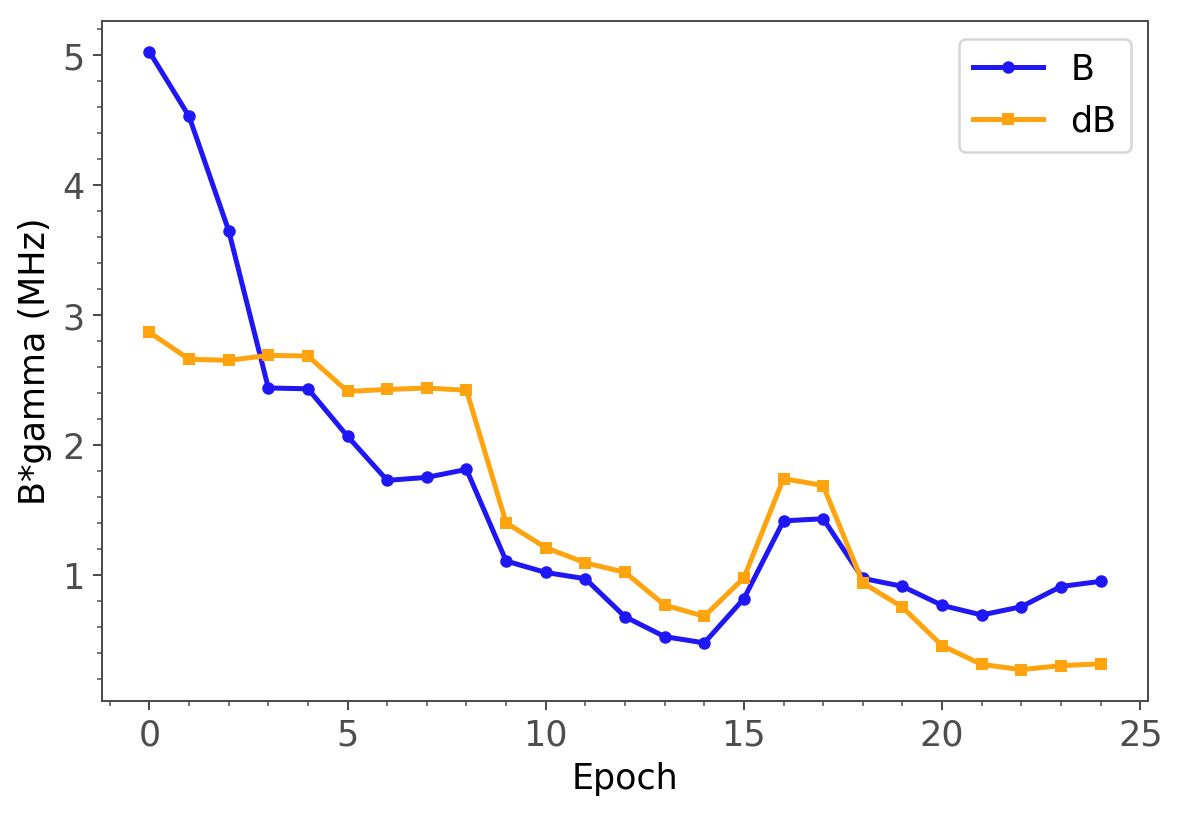

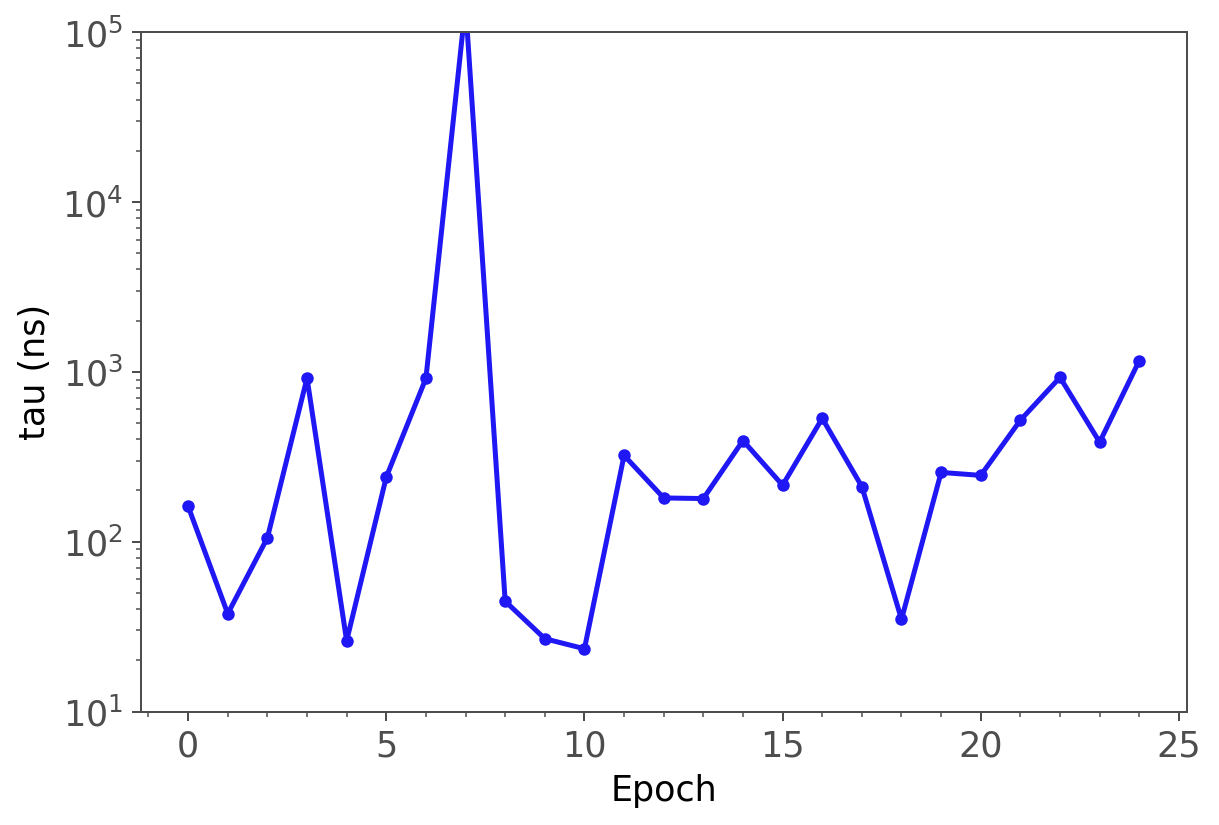

In [16]:
save_tag_0 = 'MFL'

import matplotlib.pyplot as plt
def plot_mfl_result():
    plt.plot(B_mhz, label='B')
    plt.plot(dB_mhz, label='dB')
    plt.xlabel('Epoch')
    plt.ylabel('B*gamma (MHz)')
    plt.legend()
    plt.show()
    #print(track_B)

    plt.semilogy(np.asarray(track_tau)*1e9)
    axes = plt.gca()
    axes.set_ylim([10,100000])
    plt.ylabel('tau (ns)')
    plt.xlabel('Epoch')
    plt.show()
    #print(track_tau)

# prepare results
B_mhz = (np.asarray(track_B) /(2*np.pi))[:,0]
dB_mhz =  (np.asarray(track_dB) /(2*np.pi))[:,0]
tau_ns = (np.asarray(track_tau)*1e9)[:,0]
x = np.asarray(range(0, len(track_B)))

plot_mfl_result()

# save as pulsed mes
save_tag = save_tag_0 + '_tau'
inject_data_to_current_mes(x, tau_ns, dy=dB_mhz, labels_xy=['Epoch','tau'], units_xy=['','ns'])
pulsedmasterlogic.save_measurement_data(save_tag, False)

save_tag = save_tag_0 + '_b'
inject_data_to_current_mes(x, B_mhz, dy=dB_mhz, labels_xy=['Epoch','B*gamma'], units_xy=['','MHz'])
pulsedmasterlogic.save_measurement_data(save_tag, True)





